In [14]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

In [15]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LocallyConnected1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.utils import plot_model

In [16]:
timesteps = 1440
input_dim = 1
n_epochs = 100
batch_size = 32
drop_rate = 0.8
n_samples = 6000

In [17]:
# load real-world time series trading data
def load_data(symbol):
    
    ROOT = os.path.join(r'C:\Users\vhuang\Desktop\Hazelnut', 'datasets')
    allfiles = glob.glob(os.path.join(ROOT, symbol, '*.csv'))
    n_samples = np.size(allfiles)
    
    data = np.zeros((n_samples, timesteps, input_dim))
    for i, file in enumerate(allfiles):
        df = pd.read_csv(file, usecols=[4])
        if df.values.shape[0] != timesteps:
            print(file)
            print(i + ' missing rows')
        else:
            data[i] = df.values
    
    return data

In [18]:
symbol_list = ['kiwi']
# symbol_list = ['apple', 'banana', 'cherry', 'grape', 'kiwi', 'orange']
data_dict = {}

for symbol in symbol_list:
    data_dict[symbol] = load_data(symbol)

In [19]:
def train_test_split(data):
    # training set is 0.8 of the total
    test_split = int(data.shape[0]*0.8)
    X_train_full = data[:test_split]
    X_test = data[test_split:]
    # validation set is 0.1 of the training
    valid_split = int(test_split*0.9)
    X_train = X_train_full[:valid_split]
    X_valid = X_train_full[valid_split:]
    
    return X_train, X_test, X_valid

In [20]:
RawData = data_dict['kiwi'].copy()

X_train, X_test, X_valid = train_test_split(RawData)

In [21]:
def preprocess(data):
    for i in range(data.shape[0]):
        scaler = StandardScaler()
        data[i] = scaler.fit_transform(data[i])
        
    return data

In [22]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(3866, 1440, 1)
(1075, 1440, 1)
(430, 1440, 1)


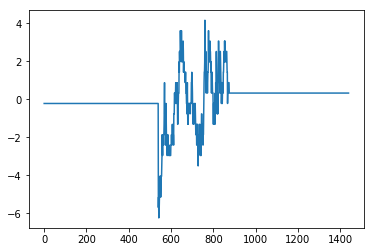

In [24]:
plt.plot(X_train[100])

In [25]:
# LocallyConnected1D Autoencoder

In [27]:
# input sequence
input_seq = Input(shape=(timesteps, input_dim))

# encoder with LocallyConnected1D and MaxPooling1D
X = LocallyConnected1D(filters=4, kernel_size=3, strides=1, padding='valid', activation='relu')(input_seq)
X = BatchNormalization()(X)
X = MaxPooling1D(6, padding='valid')(X)

X = LocallyConnected1D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling1D(6, padding='valid')(X)

X = LocallyConnected1D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(X)
X = BatchNormalization()(X)
encoded = MaxPooling1D(4, padding='valid')(X)

In [32]:
# decoder with Conv1D and UpSampling1D
X = LocallyConnected1D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(encoded)
X = BatchNormalization()(X)
X = UpSampling1D(4)(X)

X = LocallyConnected1D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(6)(X)

X = LocallyConnected1D(filters=4, kernel_size=3, strides=1, padding='valid', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(6)(X)
decoded = LocallyConnected1D(filters=1, kernel_size=3, strides=1, padding='valid', activation='sigmoid')(X)

In [33]:
LocallyConnected1DAuto_Simulation = Model(inputs=[input_seq], outputs=[decoded])

In [34]:
LocallyConnected1DAuto_Real = clone_model(LocallyConnected1DAuto_Simulation)

In [35]:
LocallyConnected1DAuto_Simulation.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1440, 1)]         0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 1438, 4)           23008     
_________________________________________________________________
batch_normalization_v2 (Batc (None, 1438, 4)           16        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 239, 4)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 237, 8)            24648     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 237, 8)            32        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 8)             0   

In [36]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('LocallyConnected1DAuto_Real.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [37]:
LocallyConnected1DAuto_Real.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [ ]:
history_real = LocallyConnected1DAuto_Real.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid))

In [ ]:
plt.plot(history_real.history['loss'])
plt.plot(history_real.history['val_loss'])

In [ ]:
X_pred = LocallyConnected1DAuto_Real.predict(X_test)

In [ ]:
plt.plot(X_pred[500])
plt.plot(X_test[500])

In [ ]:
plt.plot(X_pred[50])
plt.plot(X_test[50])

In [ ]:
# generate simulation sequence using trigonometric functions
x = np.linspace(0, 1, timesteps)
X = np.zeros((n_samples, timesteps, 1))

for i in range(n_samples):
    z = np.random.normal()
    a = np.random.random()*10
    b = np.random.random()*5
    y = np.sin(2*np.pi*a*x) + z*10*np.sin(2*np.pi*b*x)
    X[i] = y.reshape(timesteps, 1)

In [ ]:
X_train = X[:4000]
X_test = X[4500:]
X_valid = X[4000:4500]

In [ ]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_valid = preprocess(X_valid)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

In [ ]:
plt.plot(X_train[100])

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('LocallyConnected1DAuto_Simulation.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [ ]:
LocallyConnected1DAuto_Simulation.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [ ]:
history_simulation = LocallyConnected1DAuto_Simulation.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid))

In [ ]:
plt.plot(history_simulation.history['loss'])
plt.plot(history_simulation.history['val_loss'])

In [ ]:
X_pred = LocallyConnected1DAuto_Simulation.predict(X_test)

In [ ]:
plt.plot(X_pred[500])
plt.plot(X_test[500])

In [ ]:
plt.plot(X_pred[501])
plt.plot(X_test[501])

In [ ]:
plt.plot(X_pred[400])
plt.plot(X_test[400])